In [ ]:
!nvidia-smi

Sat Sep 11 16:31:27 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.63.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P8    27W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# PreProcess

ติดตั้ง Kaggle Library

In [ ]:
!pip install kaggle

Upload kaggle.json

In [ ]:
from google.colab import files

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"nuttidalapthanachai","key":"ee0a24585b49f8ef1fd3f6eab971ee01"}'}

สร้าง Folder kaggle เพื่อเก็บไฟล์ kaggle.json

In [ ]:
!mkdir kaggle

In [ ]:
!mv kaggle.json kaggle

เปลี่ยน Permission ของไฟล์ kaggle.json

In [ ]:
!chmod 600 /content/kaggle/kaggle.json

Config Kaggle Environment

In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/kaggle"

Download Cloud-image-dataset

In [ ]:
!kaggle datasets download -d nuttidalapthanachai/cloud-image-dataset

 94% 83.0M/88.1M [00:00<00:00, 138MB/s]
100% 88.1M/88.1M [00:00<00:00, 137MB/s]


สร้าง Folder Cloud-image-dataset แล้ว Unzip Dataset

In [ ]:
!mkdir cloud-image-dataset && unzip -q cloud-image-dataset.zip -d cloud-image-dataset

# Data preparation

Import Library และกำหนด parameter ที่จำเป็น

In [ ]:
import tensorflow as tf

Adam = tf.keras.optimizers.Adam
to_categorical = tf.keras.utils.to_categorical
ImageDataGenerator = tf.keras.preprocessing.image.ImageDataGenerator
ReduceLROnPlateau = tf.keras.callbacks.ReduceLROnPlateau
load_img = tf.keras.preprocessing.image.load_img
img_to_array = tf.keras.preprocessing.image.img_to_array
array_to_img = tf.keras.preprocessing.image.array_to_img

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

import plotly.graph_objs as go
from plotly import subplots
import plotly

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GRU, LSTM, Bidirectional, Embedding, Dropout, BatchNormalization
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import ModelCheckpoint

import pandas as pd
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import pickle as p

import warnings
warnings.filterwarnings('ignore')

In [ ]:
img_rows = 32
img_cols = 32
EPOCHS = 100
BATCH_SIZE = 32

Load Dataset

In [ ]:
import cv2
import os
import random
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
DIRECTORY_TRAIN = r'/content/cloud-image-dataset/train'
DIRECTORY_TEST = r'/content/cloud-image-dataset/test'
CATEGORIES = ['Cloud','RainCloud']

In [ ]:
Train_data = []
Test_data = []

for category in CATEGORIES:
  folder = os.path.join(DIRECTORY_TRAIN, category)
  label = CATEGORIES.index(category)
  for img in os.listdir(folder):
    img_path = os.path.join(folder, img)
    img_arr = cv2.imread(img_path)
    img_arr = cv2.resize(img_arr, (img_rows, img_cols))
    img_arr = cv2.cvtColor(img_arr, cv2.COLOR_BGR2GRAY)
    Train_data.append([img_arr, label])

for category in CATEGORIES:
  folder = os.path.join(DIRECTORY_TEST, category)
  label = CATEGORIES.index(category)
  for img in os.listdir(folder):
    img_path = os.path.join(folder, img)
    img_arr = cv2.imread(img_path)
    img_arr = cv2.resize(img_arr, (img_rows, img_cols))
    img_arr = cv2.cvtColor(img_arr, cv2.COLOR_BGR2GRAY)
    Test_data.append([img_arr, label])

In [ ]:
print(len(Train_data))
print(len(Test_data))

1000
200


In [ ]:
random.shuffle(Train_data)
random.shuffle(Test_data)

In [ ]:
train_data = []
y = []
test_data = []
y_test = []

for features, labels in Train_data:
  train_data.append(features)
  y.append(labels)

for features, labels in Test_data:
  test_data.append(features)
  y_test.append(labels)

In [ ]:
train_data = np.array(train_data)
y = np.array(y)
test_data = np.array(test_data)
y_test = np.array(y_test)

In [ ]:
print("train dataset-rows:",train_data.shape[0]," columns:", train_data.shape[1], " rows:", train_data.shape[2])
print("test dataset-rows:",test_data.shape[0]," columns:", test_data.shape[1], " rows:", train_data.shape[2])

train dataset-rows: 1000  columns: 32  rows: 32
test dataset-rows: 200  columns: 32  rows: 32


แสดงภาพตัวอย่างจาก Train Dataset

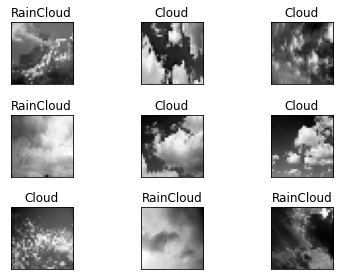

In [ ]:
for i in range(9):
    ax = plt.subplot(3, 3, 1+i)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title('%s'%(CATEGORIES[int(y[i])]))
    plt.imshow(train_data[i], cmap=plt.get_cmap('gray'))
plt.tight_layout()
plt.savefig('cloud.png', dpi=300)

ขยายมิติของ Dataset

In [ ]:
print(train_data.shape, test_data.shape)

train_data = train_data.reshape((train_data.shape[0], img_rows, img_cols, 1))
test_data = test_data.reshape((test_data.shape[0], img_rows, img_cols, 1))
print(train_data.shape, test_data.shape)

(1000, 32, 32) (200, 32, 32)
(1000, 32, 32, 1) (200, 32, 32, 1)


ทำ Scaling

In [ ]:
train_data = train_data / 255.0
test_data = test_data / 255.0

เข้ารหัสผลเฉลยแบบ One-hot Encoding

In [ ]:
print(y.shape, y_test.shape)
print(y[:9])

(1000,) (200,)
[1 0 0 1 0 0 0 1 1]


In [ ]:
y = to_categorical(y)
y_test = to_categorical(y_test)

print(y.shape, y_test.shape)
y[:9]

(1000, 2) (200, 2)


array([[0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.]], dtype=float32)

แบ่งข้อมูลสำหรับ Train และ Validate โดยการสุ่มในสัดส่วน 80:20

In [ ]:
x_train, x_val, y_train, y_val = train_test_split(train_data, y, test_size = 0.2 , random_state = 99)
x_train.shape, x_val.shape, y_train.shape, y_val.shape

((800, 32, 32, 1), (200, 32, 32, 1), (800, 2), (200, 2))

# Baseline Model

## นิยาม Model (โดยกำหนด Activate Function แบบ Sigmoid และกำหนด Output Node = 2 ใน Layer สุดท้าย)

In [ ]:
# model = Sequential()
model = tf.keras.Sequential()

#1. CNN LAYER
model.add(tf.keras.layers.Conv2D(filters = 32, kernel_size = (3,3), padding = 'Same', input_shape=(img_rows, img_cols, 1)))
model.add(tf.keras.layers.Activation("relu"))

#2. CNN LAYER
model.add(tf.keras.layers.Conv2D(filters = 32, kernel_size = (3,3), padding = 'Same'))
model.add(tf.keras.layers.Activation("relu"))

model.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2)))

#3. CNN LAYER
model.add(tf.keras.layers.Conv2D(filters = 64, kernel_size = (3,3), padding = 'Same'))
model.add(tf.keras.layers.Activation("relu"))

#4. CNN LAYER
model.add(tf.keras.layers.Conv2D(filters = 64, kernel_size = (3,3), padding = 'Same'))
model.add(tf.keras.layers.Activation("relu"))

model.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2)))

#FULLY CONNECTED LAYER
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(256))
model.add(tf.keras.layers.Activation("relu"))

#OUTPUT LAYER
model.add(tf.keras.layers.Dense(2, activation='sigmoid'))

 Compile Model (โดยกำหนด Loss Function แบบ Binary Crossentropy)

In [ ]:
optimizer = Adam()
model.compile(optimizer = optimizer, loss = "binary_crossentropy", metrics=["accuracy"])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        320       
_________________________________________________________________
activation (Activation)      (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
activation_2 (Activation)    (None, 16, 16, 64)        0

กำหนด Callbacks (เพื่อปรับลด Learning Rate)

In [ ]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience = 2, verbose=1,factor=0.1, min_lr = 0.000001)
callbacks_list = [learning_rate_reduction]

 Train Model

In [ ]:
history = model.fit(x_train, y_train,
                  batch_size= BATCH_SIZE,
                  epochs= EPOCHS,
                  callbacks=callbacks_list,
                  verbose = 1,
                  validation_data=(x_val, y_val))

Epoch 1/100
25/25 [==============================] - 3s 28ms/step - loss: 0.5328 - accuracy: 0.7300 - val_loss: 0.4107 - val_accuracy: 0.8150
Epoch 2/100
25/25 [==============================] - 0s 18ms/step - loss: 0.2832 - accuracy: 0.8913 - val_loss: 0.3620 - val_accuracy: 0.8500
Epoch 3/100
25/25 [==============================] - 0s 17ms/step - loss: 0.2475 - accuracy: 0.9050 - val_loss: 0.3781 - val_accuracy: 0.8450
Epoch 4/100
25/25 [==============================] - 0s 17ms/step - loss: 0.2620 - accuracy: 0.8975 - val_loss: 0.3497 - val_accuracy: 0.8500
Epoch 5/100
25/25 [==============================] - 0s 17ms/step - loss: 0.2286 - accuracy: 0.9150 - val_loss: 0.4267 - val_accuracy: 0.8650
Epoch 6/100
25/25 [==============================] - 0s 17ms/step - loss: 0.2789 - accuracy: 0.9100 - val_loss: 0.3903 - val_accuracy: 0.8500

Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 7/100
25/25 [==============================] - 0s 18ms/step 

นิยามกราฟ เพื่อplot acc & loss

In [ ]:
def create_trace(x,y,ylabel,color):
        trace = go.Scatter(x = x,y = y,name=ylabel,marker=dict(color=color),mode = "markers+lines",text=x)
        return trace
    
def plot_accuracy_and_loss(train_model):
    hist = train_model.history
    acc = hist['accuracy']
    val_acc = hist['val_accuracy']
    loss = hist['loss']
    val_loss = hist['val_loss']
    epochs = list(range(1,len(acc)+1))
    
    trace_ta = create_trace(epochs,acc,"Training accuracy", "Green")
    trace_va = create_trace(epochs,val_acc,"Validation accuracy", "Red")
    trace_tl = create_trace(epochs,loss,"Training loss", "Blue")
    trace_vl = create_trace(epochs,val_loss,"Validation loss", "Magenta")
   
    fig = subplots.make_subplots(rows=1,cols=2, 
                                 subplot_titles=('Training and validation accuracy','Training and validation loss'))
    fig.append_trace(trace_ta,1,1)
    fig.append_trace(trace_va,1,1)
    fig.append_trace(trace_tl,1,2)
    fig.append_trace(trace_vl,1,2)
    fig['layout']['xaxis'].update(title = 'Epoch')
    fig['layout']['xaxis2'].update(title = 'Epoch')
    fig['layout']['yaxis'].update(title = 'Accuracy', range=[0,1])
    fig['layout']['yaxis2'].update(title = 'Loss', range=[0,1])

    plotly.offline.iplot(fig, filename='accuracy-loss')

 plot accuracy & plot loss

In [ ]:
plot_accuracy_and_loss(history)

Save History

In [ ]:
filepath_history_model = 'history_model'
with open(filepath_history_model, 'wb') as file :
  p.dump(history.history, file)

In [ ]:
filepath = 'model.h5'
model.save(filepath)

Load History

In [ ]:
with open(filepath_history_model, 'rb') as file :
  his = p.load(file)

In [ ]:
predict_model = load_model(filepath)

 Evaluvate Model จาก Test Dataset

In [ ]:
score = predict_model.evaluate(test_data, y_test, verbose = 0)
print("Test Loss:",score[0])
print("Test Accuracy:",score[1])

Test Loss: 0.29678526520729065
Test Accuracy: 0.8799999952316284


 เตรียม predicted_classes และ y_true เพื่อแสดง Confuse Matrix, Precision, Recall, F1-score

In [ ]:
predicted_classes = predict_model.predict(test_data)
predicted_classes = np.argmax(predicted_classes,axis = -1)

In [ ]:
y_true = np.argmax(y_test,axis = -1)

In [ ]:
cm = confusion_matrix(y_true, predicted_classes)
np.savetxt("confusion_matrix.csv", cm, delimiter=",")
cm

array([[94,  6],
       [18, 82]])

 แสดง Confuse Matrix

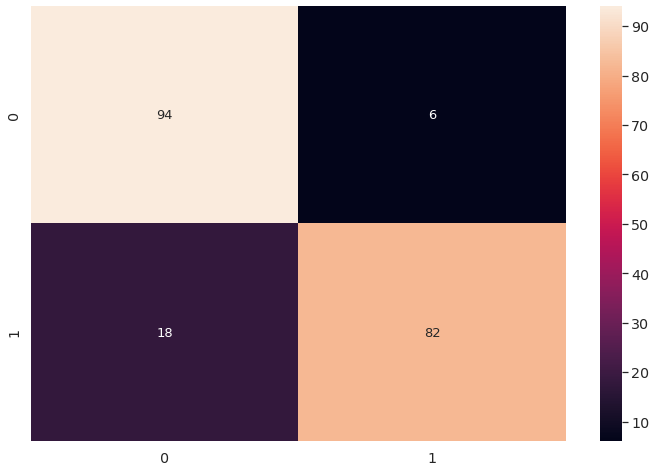

In [ ]:
import seaborn as sn
import matplotlib.pyplot as plt
df_cm = pd.DataFrame(cm, range(2), range(2))
plt.figure(figsize=(12,8))
sn.set(font_scale=1.3) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 13}, fmt='g') # for num predict size

plt.show()

 แสดง Precision, Recall, F1-score, support, accuracy, macro avg และ weighted avg

In [ ]:
report = classification_report(y_true, predicted_classes, target_names=CATEGORIES, digits=4)
print(report)

              precision    recall  f1-score   support

       Cloud     0.8393    0.9400    0.8868       100
   RainCloud     0.9318    0.8200    0.8723       100

    accuracy                         0.8800       200
   macro avg     0.8856    0.8800    0.8796       200
weighted avg     0.8856    0.8800    0.8796       200



# Image Augmentation

## นิยามวิธีการทำ Image Augmentation

In [ ]:
datagen = ImageDataGenerator(
        rotation_range=0.05,    #Randomly rotate images in the range
        zoom_range = 0.2,       #Randomly zoom image
        width_shift_range=0.1,  #Randomly shift images horizontally
        height_shift_range=0.1, #Randomly shift images vertically
        shear_range=0.05        #Randomly shear images
        )
        
datagen.fit(x_train)

ลดมิติภาพ

In [ ]:
x_batch = datagen.flow(x_train, y_train, batch_size=9).next()
print(x_batch[0].shape)
x_batch = x_batch[0].reshape((x_batch[0].shape[0], img_rows, img_cols))
print(x_batch.shape)

(9, 32, 32, 1)
(9, 32, 32)


## นิยาม Model (โดยกำหนด Activate Function แบบ Sigmoid และกำหนด Output Node = 2 ใน Layer สุดท้าย)

In [ ]:
# model = Sequential()
model = tf.keras.Sequential()

#1. CNN LAYER
model.add(tf.keras.layers.Conv2D(filters = 32, kernel_size = (3,3), padding = 'Same', input_shape=(img_rows, img_cols, 1)))
model.add(tf.keras.layers.Activation("relu"))

#2. CNN LAYER
model.add(tf.keras.layers.Conv2D(filters = 32, kernel_size = (3,3), padding = 'Same'))
model.add(tf.keras.layers.Activation("relu"))

model.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2)))

#3. CNN LAYER
model.add(tf.keras.layers.Conv2D(filters = 64, kernel_size = (3,3), padding = 'Same'))
model.add(tf.keras.layers.Activation("relu"))

#4. CNN LAYER
model.add(tf.keras.layers.Conv2D(filters = 64, kernel_size = (3,3), padding = 'Same'))
model.add(tf.keras.layers.Activation("relu"))

model.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2)))

#FULLY CONNECTED LAYER
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(256))
model.add(tf.keras.layers.Activation("relu"))

#OUTPUT LAYER
model.add(tf.keras.layers.Dense(2, activation='sigmoid'))

Compile Model (โดยกำหนด Loss Function แบบ Binary Crossentropy)

In [ ]:
optimizer = Adam()
model.compile(optimizer = optimizer, loss = "binary_crossentropy", metrics=["accuracy"])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 32, 32, 32)        320       
_________________________________________________________________
activation_5 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
activation_6 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
activation_7 (Activation)    (None, 16, 16, 64)       

Train Model

In [ ]:
history = model.fit(datagen.flow(x_train, y_train, batch_size=BATCH_SIZE),
                              shuffle=True,
                              epochs=EPOCHS,
                              callbacks=callbacks_list, 
                              validation_data = (x_val, y_val),
                              verbose=1, 
                              steps_per_epoch=x_train.shape[0] // BATCH_SIZE)

Epoch 1/100
25/25 [==============================] - 2s 34ms/step - loss: 0.6106 - accuracy: 0.6263 - val_loss: 0.4483 - val_accuracy: 0.7900
Epoch 2/100
25/25 [==============================] - 1s 25ms/step - loss: 0.4074 - accuracy: 0.8350 - val_loss: 0.3566 - val_accuracy: 0.8500
Epoch 3/100
25/25 [==============================] - 1s 28ms/step - loss: 0.2935 - accuracy: 0.8813 - val_loss: 0.3484 - val_accuracy: 0.8300
Epoch 4/100
25/25 [==============================] - 1s 26ms/step - loss: 0.2829 - accuracy: 0.8875 - val_loss: 0.3507 - val_accuracy: 0.8300
Epoch 5/100
25/25 [==============================] - 1s 25ms/step - loss: 0.2798 - accuracy: 0.8913 - val_loss: 0.3715 - val_accuracy: 0.8550

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 6/100
25/25 [==============================] - 1s 27ms/step - loss: 0.2390 - accuracy: 0.9087 - val_loss: 0.3754 - val_accuracy: 0.8550
Epoch 7/100
25/25 [==============================] - 1s 27ms/step 

plot accuracy & plot loss

In [ ]:
plot_accuracy_and_loss(history)

Save History

In [ ]:
filepath_history_model = 'history_model'
with open(filepath_history_model, 'wb') as file :
  p.dump(history.history, file)

In [ ]:
filepath = 'model.h5'
model.save(filepath)

Load History

In [ ]:
with open(filepath_history_model, 'rb') as file :
  his = p.load(file)

In [ ]:
predict_model = load_model(filepath)

Evaluvate Model

In [ ]:
score = predict_model.evaluate(test_data, y_test, verbose = 0)
print("Test Loss:",score[0])
print("Test Accuracy:",score[1])

Test Loss: 0.3201884925365448
Test Accuracy: 0.8650000095367432


เตรียม ทำCM

In [ ]:
predicted_classes = predict_model.predict(test_data)
predicted_classes = np.argmax(predicted_classes,axis = -1)

In [ ]:
y_true = np.argmax(y_test,axis = -1)

In [ ]:
cm = confusion_matrix(y_true, predicted_classes)
np.savetxt("confusion_matrix.csv", cm, delimiter=",")
cm

array([[90, 10],
       [17, 83]])

แสดงconfuse matrix

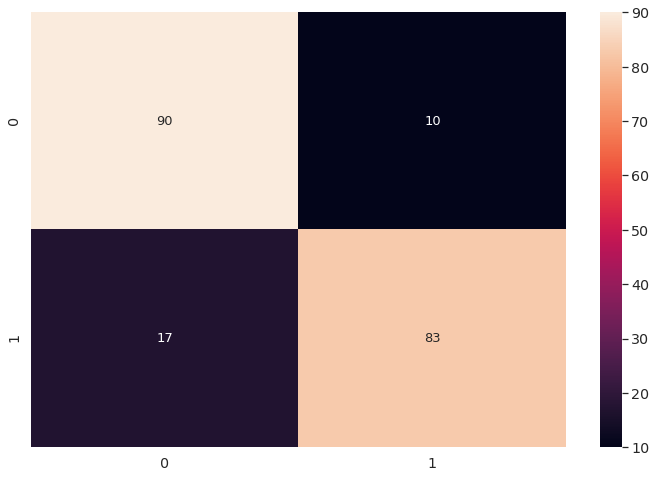

In [ ]:
import seaborn as sn
import matplotlib.pyplot as plt

df_cm = pd.DataFrame(cm, range(2), range(2))
plt.figure(figsize=(12,8))
sn.set(font_scale=1.3) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 13}, fmt='g') # for num predict size

plt.show()

แสดง Precision recall

In [ ]:
report = classification_report(y_true, predicted_classes, target_names=CATEGORIES, digits=4)

print(report)

              precision    recall  f1-score   support

       Cloud     0.8411    0.9000    0.8696       100
   RainCloud     0.8925    0.8300    0.8601       100

    accuracy                         0.8650       200
   macro avg     0.8668    0.8650    0.8648       200
weighted avg     0.8668    0.8650    0.8648       200



# Batch Normalization

## นิยามวิธีการทำ Image Augmentation

In [ ]:
datagen = ImageDataGenerator(
        rotation_range=0.05,    #Randomly rotate images in the range
        zoom_range = 0.2,       #Randomly zoom image
        width_shift_range=0.1,  #Randomly shift images horizontally
        height_shift_range=0.1, #Randomly shift images vertically
        shear_range=0.05        #Randomly shear images
        )

datagen.fit(x_train)

## นิยาม Model (โดยกำหนด BatchNormalization())

In [ ]:
# model = Sequential()
model = tf.keras.Sequential()

#1. CNN LAYER
model.add(tf.keras.layers.Conv2D(filters = 32, kernel_size = (3,3), padding = 'Same', input_shape=(img_rows, img_cols, 1)))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Activation("relu"))

#2. CNN LAYER
model.add(tf.keras.layers.Conv2D(filters = 32, kernel_size = (3,3), padding = 'Same'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Activation("relu"))

model.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2)))

#3. CNN LAYER
model.add(tf.keras.layers.Conv2D(filters = 64, kernel_size = (3,3), padding = 'Same'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Activation("relu"))

#4. CNN LAYER
model.add(tf.keras.layers.Conv2D(filters = 64, kernel_size = (3,3), padding = 'Same'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Activation("relu"))

model.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2)))

#FULLY CONNECTED LAYER
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(256))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Activation("relu"))

#OUTPUT LAYER
model.add(tf.keras.layers.Dense(2, activation='sigmoid'))

compile model

In [ ]:
optimizer = Adam()
model.compile(optimizer = optimizer, loss = "binary_crossentropy", metrics=["accuracy"])

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 32, 32, 32)        320       
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 32)        128       
_________________________________________________________________
activation_10 (Activation)   (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
activation_11 (Activation)   (None, 32, 32, 32)        0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 16, 16, 32)       

train model

In [ ]:
history = model.fit(datagen.flow(x_train, y_train, batch_size=BATCH_SIZE),
                              shuffle=True,
                              epochs= EPOCHS,
                              callbacks=callbacks_list, 
                              validation_data = (x_val, y_val),
                              verbose=1, 
                              steps_per_epoch=x_train.shape[0] // BATCH_SIZE)

Epoch 1/100
25/25 [==============================] - 2s 40ms/step - loss: 0.2869 - accuracy: 0.8888 - val_loss: 0.8264 - val_accuracy: 0.5250
Epoch 2/100
25/25 [==============================] - 1s 28ms/step - loss: 0.1921 - accuracy: 0.9212 - val_loss: 1.1771 - val_accuracy: 0.5250
Epoch 3/100
25/25 [==============================] - 1s 29ms/step - loss: 0.1938 - accuracy: 0.9250 - val_loss: 1.3864 - val_accuracy: 0.5250

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 4/100
25/25 [==============================] - 1s 29ms/step - loss: 0.1536 - accuracy: 0.9425 - val_loss: 1.4747 - val_accuracy: 0.5250
Epoch 5/100
25/25 [==============================] - 1s 29ms/step - loss: 0.1457 - accuracy: 0.9425 - val_loss: 1.6145 - val_accuracy: 0.5250

Epoch 00005: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Epoch 6/100
25/25 [==============================] - 1s 28ms/step - loss: 0.1438 - accuracy: 0.9500 - val_loss: 1.7038 - val_a

plot accuracy & plot loss

In [ ]:
plot_accuracy_and_loss(history)

save history

In [ ]:
filepath_history_model = 'history_model'
with open(filepath_history_model, 'wb') as file :
  p.dump(history.history, file)

In [ ]:
filepath = 'model.h5'
model.save(filepath)

load history

In [ ]:
with open(filepath_history_model, 'rb') as file :
  his = p.load(file)

In [ ]:
predict_model = load_model(filepath)

evaluate model

In [ ]:
score = predict_model.evaluate(test_data, y_test, verbose = 0)
print("Test Loss:",score[0])
print("Test Accuracy:",score[1])

Test Loss: 0.19963139295578003
Test Accuracy: 0.9200000166893005


เตรียมทำcm

In [ ]:
predicted_classes = predict_model.predict(test_data)
predicted_classes = np.argmax(predicted_classes,axis = -1)

In [ ]:
y_true = np.argmax(y_test,axis = -1)

In [ ]:
cm = confusion_matrix(y_true, predicted_classes)
np.savetxt("confusion_matrix.csv", cm, delimiter=",")
cm

array([[91,  9],
       [ 7, 93]])

แสดงconfution matrix

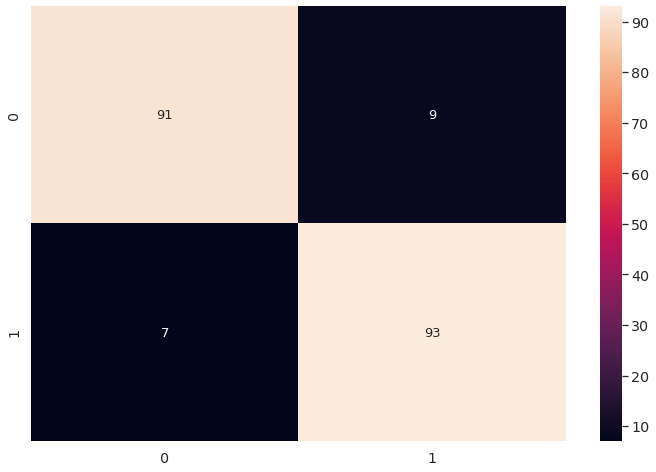

In [ ]:
import seaborn as sn
import matplotlib.pyplot as plt

df_cm = pd.DataFrame(cm, range(2), range(2))
plt.figure(figsize=(12,8))
sn.set(font_scale=1.3) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 13}, fmt='g') # for num predict size

plt.show()

แสดง Precision

In [ ]:
report = classification_report(y_true, predicted_classes, target_names=CATEGORIES, digits=4)

print(report)

              precision    recall  f1-score   support

       Cloud     0.9286    0.9100    0.9192       100
   RainCloud     0.9118    0.9300    0.9208       100

    accuracy                         0.9200       200
   macro avg     0.9202    0.9200    0.9200       200
weighted avg     0.9202    0.9200    0.9200       200



# Dropout

## นิยามวิธีการทำ Image Augmentation

In [ ]:
datagen = ImageDataGenerator(
        rotation_range=0.05,    #Randomly rotate images in the range
        zoom_range=0.2,         #Randomly zoom image
        width_shift_range=0.1,  #Randomly shift images horizontally
        height_shift_range=0.1, #Randomly shift images vertically
        shear_range=0.05        #Randomly shear images
        )

datagen.fit(x_train)

## นิยาม Model (โดยกำหนด Dropout(0.1))

In [ ]:
# model = Sequential()
model = tf.keras.Sequential()

#1. CNN LAYER
model.add(tf.keras.layers.Conv2D(filters = 32, kernel_size = (3,3), padding = 'Same', input_shape=(img_rows, img_cols, 1)))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Activation("relu"))
model.add(tf.keras.layers.Dropout(0.1))

#2. CNN LAYER
model.add(tf.keras.layers.Conv2D(filters = 32, kernel_size = (3,3), padding = 'Same'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Activation("relu"))

model.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2)))
model.add(tf.keras.layers.Dropout(0.1))

#3. CNN LAYER
model.add(tf.keras.layers.Conv2D(filters = 64, kernel_size = (3,3), padding = 'Same'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Activation("relu"))
model.add(tf.keras.layers.Dropout(0.1))

#4. CNN LAYER
model.add(tf.keras.layers.Conv2D(filters = 64, kernel_size = (3,3), padding = 'Same'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Activation("relu"))

model.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2)))
model.add(tf.keras.layers.Dropout(0.1))


#FULLY CONNECTED LAYER
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(256))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Activation("relu"))
model.add(tf.keras.layers.Dropout(0.1))

#OUTPUT LAYER
model.add(tf.keras.layers.Dense(2, activation='sigmoid'))

0.2 -- 0.8600
0.3 -- 0.7400
0.4 -- 0.5500
0.5 -- 0.7...
 

complie model

In [ ]:
optimizer = Adam()
model.compile(optimizer = optimizer, loss = "binary_crossentropy", metrics=["accuracy"])

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 32, 32, 32)        320       
_________________________________________________________________
batch_normalization_5 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
activation_15 (Activation)   (None, 32, 32, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_6 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
activation_16 (Activation)   (None, 32, 32, 32)       

train model

In [ ]:
history = model.fit(datagen.flow(x_train, y_train, batch_size=BATCH_SIZE),
                              shuffle=True,
                              epochs=EPOCHS,
                              callbacks=callbacks_list, 
                              validation_data = (x_val, y_val),
                              verbose = 1, 
                              steps_per_epoch=x_train.shape[0] // BATCH_SIZE)

Epoch 1/100
25/25 [==============================] - 2s 39ms/step - loss: 0.3659 - accuracy: 0.8500 - val_loss: 0.7357 - val_accuracy: 0.5250
Epoch 2/100
25/25 [==============================] - 1s 31ms/step - loss: 0.2289 - accuracy: 0.9038 - val_loss: 1.2812 - val_accuracy: 0.5250
Epoch 3/100
25/25 [==============================] - 1s 31ms/step - loss: 0.2078 - accuracy: 0.9250 - val_loss: 1.6813 - val_accuracy: 0.5250

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 4/100
25/25 [==============================] - 1s 29ms/step - loss: 0.1698 - accuracy: 0.9413 - val_loss: 1.8992 - val_accuracy: 0.5250
Epoch 5/100
25/25 [==============================] - 1s 29ms/step - loss: 0.1573 - accuracy: 0.9400 - val_loss: 2.1175 - val_accuracy: 0.5250

Epoch 00005: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Epoch 6/100
25/25 [==============================] - 1s 28ms/step - loss: 0.1561 - accuracy: 0.9375 - val_loss: 2.2541 - val_a

plot acc & plot loss

In [ ]:
plot_accuracy_and_loss(history)

save history

In [ ]:
filepath_history_model = 'history_model'
with open(filepath_history_model, 'wb') as file :
  p.dump(history.history, file)

In [ ]:
filepath = 'model.h5'
model.save(filepath)

load history

In [ ]:
with open(filepath_history_model, 'rb') as file :
  his = p.load(file)

In [ ]:
predict_model = load_model(filepath)

evaluvate model

In [ ]:
score = predict_model.evaluate(test_data, y_test, verbose = 0)
print("Test Loss:",score[0])
print("Test Accuracy:",score[1])

Test Loss: 0.20871269702911377
Test Accuracy: 0.8899999856948853


เตรียมทำcm 

In [ ]:
predicted_classes = predict_model.predict(test_data)
predicted_classes = np.argmax(predicted_classes,axis = -1)

In [ ]:
y_true = np.argmax(y_test,axis = -1)

In [ ]:
cm = confusion_matrix(y_true, predicted_classes)
np.savetxt("confusion_matrix.csv", cm, delimiter=",")
cm

array([[83, 17],
       [ 5, 95]])

แสดง confusion matrix

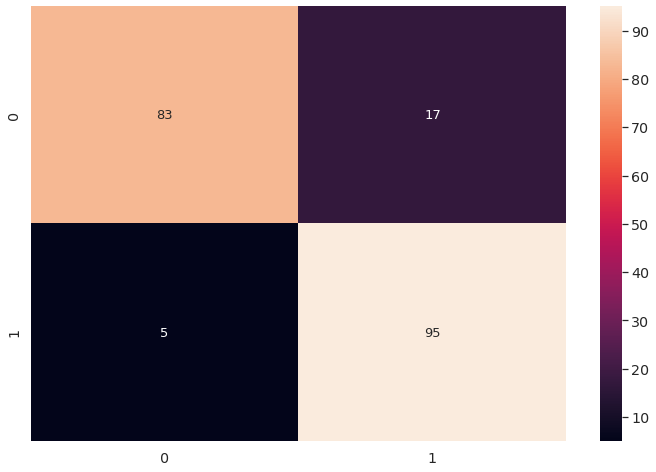

In [ ]:
import seaborn as sn
import matplotlib.pyplot as plt

df_cm = pd.DataFrame(cm, range(2), range(2))
plt.figure(figsize=(12,8))
sn.set(font_scale=1.3) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 13}, fmt='g') # for num predict size

plt.show()

แสดง precision 

In [ ]:
report = classification_report(y_true, predicted_classes, target_names=CATEGORIES, digits=4)

print(report)

              precision    recall  f1-score   support

       Cloud     0.9432    0.8300    0.8830       100
   RainCloud     0.8482    0.9500    0.8962       100

    accuracy                         0.8900       200
   macro avg     0.8957    0.8900    0.8896       200
weighted avg     0.8957    0.8900    0.8896       200

